# Modelling

In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [2]:
import pandas as pd
df = pd.read_csv('../data/wine_data.csv', sep=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
X, y = df.drop('quality', axis=1), df.quality

Prior to any modelling, we need to pick a way of evaluating its performance. Because the model will be used in a pricing model, it is very important that the prediction is as close as possible to reality. We don't mind if the predictions are above or below in quality predictions: only how accurate they are. I've decided the the Mean Absolute Error and Root-Mean Square Error are the best measures of this.

Naturally, with these metrics decided upon, will build a regression model over a classification model since it better fits in with the evaluation metrics that we've set. I'll also capture $R^2$ score as it is a handy measure for regression models.

We will compare our model's performance against the naive model of the mode of the population.

In [5]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

def root_mean_squared_error(*args, **kwargs):
    return mean_squared_error(*args, **kwargs)**0.5

In [6]:
results = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model = DummyRegressor()
    model = model.fit(X_train, y_train) 
    y_hat = model.predict(X_test)
    
    results_dict = {
        'mae': mean_absolute_error(y_test, y_hat),
        'rmse': root_mean_squared_error(y_test, y_hat),
        'r2': r2_score(y_test, y_hat)
    }
    results.append(results_dict)
print("BASELINE AVERAGE MAE:", sum([fold['mae'] for fold in results]) / len(results))
print("BASELINE AVERAGE RMSE:", sum([fold['rmse'] for fold in results]) / len(results))
print("BASELINE AVERAGE R2:", sum([fold['r2'] for fold in results]) / len(results))

BASELINE AVERAGE MAE: 0.6709238413126002
BASELINE AVERAGE RMSE: 0.8854708703830904
BASELINE AVERAGE R2: -0.002245018955469291


## Model Selection 

### Model 1: XGBoost without Feature Engineering

The first improvement to make would be to train an XGBoost model without adding any feature engineering.

In [7]:
import xgboost
N_SPLITS = 10

results = []
kf = KFold(n_splits=N_SPLITS, shuffle=True)
with tqdm(total=N_SPLITS) as pbar:
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model = xgboost.XGBRegressor(objective ='reg:squarederror')
        model = model.fit(X_train, y_train) 
        y_hat = model.predict(X_test)

        results_dict = {
            'mae': mean_absolute_error(y_test, y_hat),
            'rmse': root_mean_squared_error(y_test, y_hat),
            'r2': r2_score(y_test, y_hat),
        }
        results.append(results_dict)
        pbar.update(1)
print("XGB AVERAGE MAE:", sum([fold['mae'] for fold in results]) / len(results))
print("XGB AVERAGE RMSE:", sum([fold['rmse'] for fold in results]) / len(results))
print("XGB AVERAGE R2:", sum([fold['r2'] for fold in results]) / len(results))

100%|██████████| 10/10 [00:01<00:00,  8.04it/s]

XGB AVERAGE MAE: 0.5378408079048633
XGB AVERAGE RMSE: 0.6885689037339439
XGB AVERAGE R2: 0.39334743110494486


Already we have an improvement without any hyperparameter tuning! That's a promising sign. It looks as if we are getting a weak predictor of the quality of the wine. On average, our predictions are approximately half a point away from reality.

Let's look at the distributions of the real and test data on the last fold to get an understanding of this behaviour.

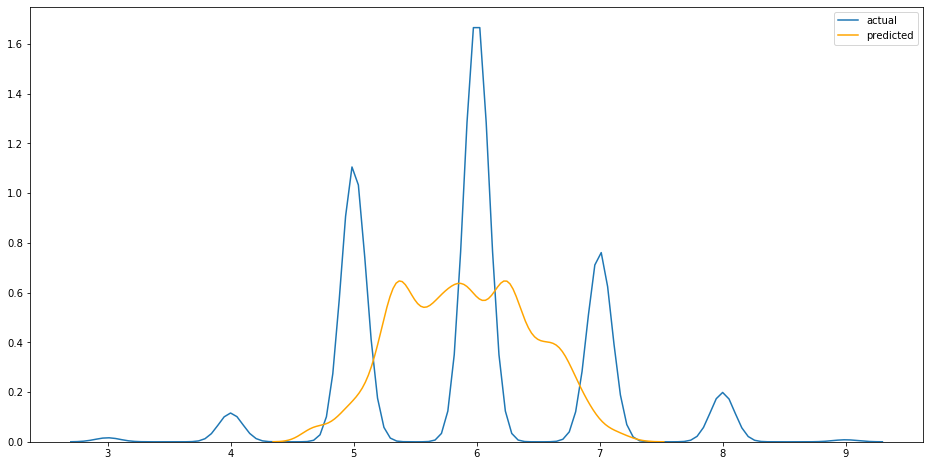

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(16, 8))

actual = sns.kdeplot(y_test, label='actual', ax=ax, bw=0.1)
predicted = sns.kdeplot(y_hat, label='predicted', ax=ax, color='orange', bw=0.1)

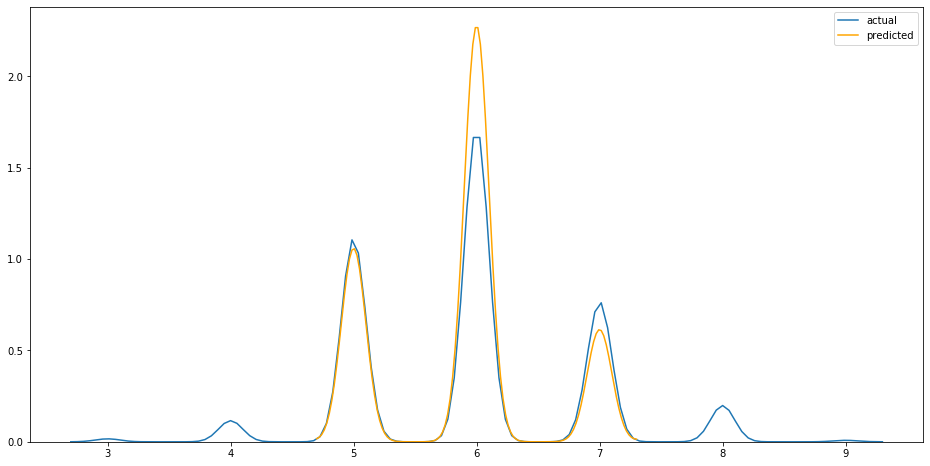

In [9]:
f, ax = plt.subplots(figsize=(16, 8))

actual = sns.kdeplot(y_test, label='actual', ax=ax, bw=0.1)
predicted = sns.kdeplot([round(x) for x in y_hat], label='predicted', ax=ax, color='orange', bw=0.1)

We can tell that the model doesn't like predicting values at the extremes. This is likely a result of a class inbalance that we saw in the EDA.

### Model 2: XGBoost with Undersampling

It looks that there is a strong inbalance between the different quality scores. To improve the model's performance at the extreme scores, let's investigate undersampling the predicted scores.

There are no objects in Scikit learn which handle undersampling for us so we will have to do it ourselves. We will stick with random undersampling for the moment - we can investigate more complex solutions in the future.

In [10]:
def undersample(dataframe, target_column, alpha=1.0):
    """Undersamples a dataframe.
    
    Args:
        df (pd.Dataframe): Original dataframe with unbalanced classes.
        target (str): The column that references the target in df.
        alpha (float): The "agressiveness" of the undersampling. Expresses the 
            amount to correct the classes by. Defaults to 1.0.
            
    Returns:
        (pd.Dataframe): A randomly undersampled dataframe.
    """
    ## Determine the sampling rates ##
    class_counts = dataframe[target_column].value_counts()
    smallest_count = class_counts.min()
    raw_sample_diffs = class_counts - smallest_count
    adjusted_sample_diffs = (raw_sample_diffs * alpha).astype(int)
    target_sample_rates = class_counts - adjusted_sample_diffs
    
    ## Randomly sample those amounts from the dataframe
    dfs = []
    for target, n_sample in target_sample_rates.iteritems():
        dfs.append(
            dataframe[dataframe[target_column] == target]
            .sample(n=n_sample)
        )
    
    ## Concatenate those sampled dataframes together ##
    dff = (
        pd.concat(dfs)
        .sample(frac=1.0)
        .reset_index(drop=True)
    )
    return dff

In [11]:
dff = undersample(df, target_column='quality', alpha=0.5)
print(df.shape)
print(dff.shape)

(4898, 12)
(2468, 12)


Let's now try this technique on the model and see if the performance improves.

In [12]:
N_SPLITS = 10

for alpha in [0.0, 0.1, 0.2, 0.5, 0.7, 0.9, 1.0]:
    dff = undersample(df, target_column='quality', alpha=alpha)
    X, y = dff.drop('quality', axis=1), dff.quality

    results = []
    kf = KFold(n_splits=N_SPLITS, shuffle=True)
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model = xgboost.XGBRegressor(objective ='reg:squarederror')
        model = model.fit(X_train, y_train) 
        y_hat = model.predict(X_test)

        results_dict = {
            'mae': mean_absolute_error(y_test, y_hat),
            'rmse': root_mean_squared_error(y_test, y_hat),
            'r2': r2_score(y_test, y_hat),
        }
        results.append(results_dict)
    print(f"== ALPHA: {alpha} ==")
    print("XGB AVERAGE MAE:", sum([fold['mae'] for fold in results]) / len(results))
    print("XGB AVERAGE RMSE:", sum([fold['rmse'] for fold in results]) / len(results))
    print("XGB AVERAGE R2:", sum([fold['r2'] for fold in results]) / len(results))
    print()

== ALPHA: 0.0 ==
XGB AVERAGE MAE: 0.5377292790612307
XGB AVERAGE RMSE: 0.687521041682331
XGB AVERAGE R2: 0.3952963968471593

== ALPHA: 0.1 ==
XGB AVERAGE MAE: 0.5386669181600491
XGB AVERAGE RMSE: 0.6915083274317195
XGB AVERAGE R2: 0.39029390571395967

== ALPHA: 0.2 ==
XGB AVERAGE MAE: 0.5437102892629492
XGB AVERAGE RMSE: 0.6953260778531579
XGB AVERAGE R2: 0.38481488134347036

== ALPHA: 0.5 ==
XGB AVERAGE MAE: 0.5471960310625051
XGB AVERAGE RMSE: 0.7048138743559821
XGB AVERAGE R2: 0.38008668391307043

== ALPHA: 0.7 ==
XGB AVERAGE MAE: 0.5632738395089272
XGB AVERAGE RMSE: 0.7293462535764819
XGB AVERAGE R2: 0.36476682603007593

== ALPHA: 0.9 ==
XGB AVERAGE MAE: 0.6384974620857847
XGB AVERAGE RMSE: 0.8343353594138403
XGB AVERAGE R2: 0.24826002837140898

== ALPHA: 1.0 ==
XGB AVERAGE MAE: 1.1352001865704855
XGB AVERAGE RMSE: 1.3948682877547487
XGB AVERAGE R2: 0.28448402549324214



The random undersampling appears to have actually worsened the model based off the metrics we are using to evaluate the model. 

## Feature Engineering

This section is a work in progress. We will investigate model improvement due to feature engineering after the first version of the final system.